In [1]:
import numpy as np
from numpy.random import uniform
from scipy.integrate import quad as integrate
from scipy.integrate import dblquad as integrate2D
import scipy.optimize
import scipy.special as sc
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [2]:
# Constants
mu_0 = 4*np.pi*10**-7

In [3]:
def thin_coil_z(r, R, z, curr): 
    
    """returns the Bz field of single wire
    
    r = radial position of interest from z axis (coil axis)
    R = radiius of the coil
    z = z-distance from the centre of the coil to point of interest 
    curr = current of the coil
    
    """
    
    k = 4*R*r/(z**2+(R+r)**2) # variable in elliptic integral
    E1 = sc.ellipk(k) # 1st kind elliptic integral
    E2 = sc.ellipe(k) # 2nd kind elliptic integral
    
    return (((R**2-z**2-r**2)*E2)/(z**2+(r-R)**2)+E1)*mu_0*curr/(2*np.pi*np.sqrt(z**2+(R+r)**2))

In [4]:
def thin_coil_r(r, R, z, curr):

    """returns the Br field of single wire
    
    r = radial position of interest from z axis (coil axis)
    R = radiius of the coil
    z = z-distance from the centre of the coil to point of interest 
    curr = current of the coil
    
    """
    
    k = 4*R*r/(z**2+(R+r)**2) # variable in elliptic integral
    E1 = sc.ellipk(k) # 1st kind elliptic integral
    E2 = sc.ellipe(k) # 2nd kind elliptic integral 
    
    return (((z**2+r**2+R**2)*E2)/(z**2+(r-R)**2)-E1)*mu_0*curr*z/(2*np.pi*r*np.sqrt(z**2+(R+r)**2))

In [5]:
def thick_coil(r, R0, z0, curr, n, L, t): 
    
    """returns the Br and Bz of thick coil, with radial thickness t and axial length L, 2D integral
    
    r = radial position of interest from z axis (coil axis)
    R0 = inner radius of the coil
    z0 = z-distance from the centre of the coil(closest surface) to point of interest 
    curr = current of the coil
    n = n turns per m^2
    (curr*n = current density)
    L = length of the coil
    t = thickness of the coil
    
    """
    
    Bz_thick = integrate2D(lambda R, z: thin_coil_z(r, R, z, curr)*n, z0, z0+L, lambda R: R0, lambda R: R0+t)[0]
    Br_thick = integrate2D(lambda R, z: thin_coil_r(r, R, z, curr)*n, z0, z0+L, lambda R: R0, lambda R: R0+t)[0]
    
    return np.array([Br_thick, Bz_thick])

In [6]:
def cost(x, n1, n2, n3):
    """
    n1, n2, n3 are either +1 or -1, depends on the current direction
    3 pairs of coils, each with Rn, tn, zn, Ln
    Returns the cost function value of the system
    
    """
    R1 = x[0]
    t1 = x[1]
    z1 = x[2]
    L1 = x[3]
    
    R2 = x[4]
    t2 = x[5]
    z2 = x[6]
    L2 = x[7]
    
    R3 = x[8]
    t3 = x[9]
    z3 = x[10]
    L3 = x[11]
    
    curr = 1e8 #just to have 100A per mm^2 
    gap = 0.001 # 1mm, meshing 10mm*10mm plate into 100 pieces, decompose ion-trap into 100 squares, each square's centre is a test point
    
    B_trap = np.zeros((10, 10))

    for i in range(10):
        
        r = -0.0045 # depends on the size of ion-trap
        
        for j in range(10):

            B_single_point1 = thick_coil(r+j*gap, R1, z1-0.0045+i*gap, curr, n1, L1, t1) + thick_coil(r+j*gap, R2, z2-0.0045+i*gap, curr, n2, L2, t2) + thick_coil(r+j*gap, R3, z3-0.0045+i*gap, curr, n3, L3, t3)
            B_single_point2 = thick_coil(-r-j*gap, R1, z1+0.0045-i*gap, curr, n1, L1, t1) + thick_coil(-r-j*gap, R2, z2+0.0045-i*gap, curr, n2, L2, t2) + thick_coil(-r-j*gap, R3, z3+0.0045-i*gap, curr, n3, L3, t3)
                
            B_single_r = B_single_point1[0] + B_single_point2[0] # r-component of B-field
            B_single_z = B_single_point1[1] + B_single_point2[1] # z-component of B-field
            
            B_trap[j,i] = np.sqrt(B_single_r**2 + B_single_z**2)
        
    B_mean = np.mean(B_trap)
   
    cst=np.sum((B_trap-B_mean)**2)/B_mean**2
    
    return cst

In [7]:
def meanB(x, n1, n2, n3):
    """
    n1, n2, n3 are either +1 or -1, depends on the current direction
    3 pairs of coils, each with Rn, tn, zn, Ln, currn
    Returns the efficiency of the system.
    
    """
    R1 = x[0]
    t1 = x[1]
    z1 = x[2]
    L1 = x[3]
    
    R2 = x[4]
    t2 = x[5]
    z2 = x[6]
    L2 = x[7]
    
    R3 = x[8]
    t3 = x[9]
    z3 = x[10]
    L3 = x[11]

    curr = 1e8 
    gap = 0.001 # 1mm, meshing 10mm*10mm plate into 100 pieces 
    
    B_trap = np.zeros((10, 10))

    for i in range(10):
        
        r = -0.0045 # depends on the size of ion-trap

        for j in range(10):
            
            B_single_point1 = thick_coil(r+j*gap, R1, z1-0.0045+i*gap, curr, n1, L1, t1) + thick_coil(r+j*gap, R2, z2-0.0045+i*gap, curr, n2, L2, t2) + thick_coil(r+j*gap, R3, z3-0.0045+i*gap, curr, n3, L3, t3)
            B_single_point2 = thick_coil(-r-j*gap, R1, z1+0.0045-i*gap, curr, n1, L1, t1) + thick_coil(-r-j*gap, R2, z2+0.0045-i*gap, curr, n2, L2, t2) + thick_coil(-r-j*gap, R3, z3+0.0045-i*gap, curr, n3, L3, t3)
                
            B_single_r = B_single_point1[0] + B_single_point2[0] # r-component of B-field
            B_single_z = B_single_point1[1] + B_single_point2[1] # z-component of B-field
            
            B_trap[j,i] = np.sqrt(B_single_r**2 + B_single_z**2)
            
    B_mean = np.mean(B_trap)
    
    return B_mean

In [8]:
def std(x, n1, n2, n3):
    """
    n1, n2, n3 are either +1 or -1, depends on the current direction
    3 pairs of coils, each with Rn, tn, zn, Ln, currn
    Returns standard deviation of the system

    """
    R1 = x[0]
    t1 = x[1]
    z1 = x[2]
    L1 = x[3]
    
    R2 = x[4]
    t2 = x[5]
    z2 = x[6]
    L2 = x[7]
    
    R3 = x[8]
    t3 = x[9]
    z3 = x[10]
    L3 = x[11]
    
    curr = 1e8
    gap = 0.001 # 1mm, meshing 10mm*10mm plate into 100 pieces 


    B_trap = np.zeros((10, 10))

    for i in range(10):
        
        r = -0.0045 # depends on the size of ion-trap
        
        for j in range(10):
            
            B_single_point1 = thick_coil(r+j*gap, R1, z1-0.0045+i*gap, curr, n1, L1, t1) + thick_coil(r+j*gap, R2, z2-0.0045+i*gap, curr, n2, L2, t2) + thick_coil(r+j*gap, R3, z3-0.0045+i*gap, curr, n3, L3, t3)
            B_single_point2 = thick_coil(-r-j*gap, R1, z1+0.0045-i*gap, curr, n1, L1, t1) + thick_coil(-r-j*gap, R2, z2+0.0045-i*gap, curr, n2, L2, t2) + thick_coil(-r-j*gap, R3, z3+0.0045-i*gap, curr, n3, L3, t3)
                
            B_single_r = B_single_point1[0] + B_single_point2[0] # r-component of B-field
            B_single_z = B_single_point1[1] + B_single_point2[1] # z-component of B-field
            
            B_trap[j,i] = np.sqrt(B_single_r**2 + B_single_z**2)
        
        
    deviation = np.std(B_trap)    
       
    return deviation

In [10]:
def generate_coil(start, end):
    """
    Generate random configuration of a coil
    
    R = inner radius of the coil
    t = thickness of the coil
    z = gap between center of ion-trap and closest surface of the coil
    L = length of the coil
    """
    min_t = 0.005
    min_L = 0.005
    
    R = uniform(0.085, 0.17-min_t)
    t = uniform(min_t, 0.17-R)
    z = uniform(start, end-min_L)
    L = uniform(min_L, 0.03)
    
    x = [R, t, z, L] #use list, not np.array in order to do coil1+coil2+coil3, to have 12-variable list
    
    return x

[0.15528022 0.00568468 0.01409895 0.01957415 0.10207713 0.00651278
 0.06978357 0.02375737 0.14700875 0.01984368 0.07743661 0.02163038]
The cost function value of the system is 6.011436e-09.
The mean B Field of the system is 5.081157e-02 [T].
The standard deviation of the system is 3.939597e-07.
The sign of currents of coils are ++-.


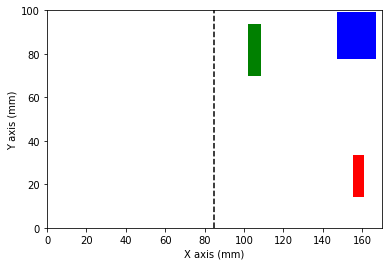

In [17]:
num_samples = 100

x = np.zeros((num_samples, 12))

C_ppp = np.zeros(num_samples)
C_ppm = np.zeros(num_samples)
C_pmp = np.zeros(num_samples)
C_pmm = np.zeros(num_samples)

for i in range(num_samples):
    
    coil1 = generate_coil(0, 0.02) # randomly choose 1st coil's configuratioon

    while True: # with fixed 1st coil
        coil2 = generate_coil(coil1[2], 0.1) # z2 starts higher than z1

        if coil2[2] >= coil1[2]+coil1[3]: # z2 >= z1+L1 (No overlapping in z)
            break
        else: # z1 <= z2 < z1+L1 (overlapping)
            if coil2[0]+coil2[1] <= coil1[0] or coil2[0] >= coil1[0]+coil1[1]: # R2 + t2 <=R1 or R2 >= R1+t1
                break

    while True: # We've set coil1 and coil2. Now, it's time to set coil3           
        coil3 = generate_coil(coil2[2], 0.1) #z3 starts higher than z2 (and z1)

        if coil2[2] >= coil1[2] + coil1[3]: # case1: if coil2 is not overlapped completely in z with coil1
            if coil3[2] >= coil2[2] + coil2[3]: # z3 >= z2+L2
                break
            else:
                 if coil3[0]+coil3[1] <= coil2[0] or coil3[0] >= coil2[0]+coil2[1]: # R3+t3 <= R2 or R3 >= R2+t2
                    break


        if coil2[2] < coil1[2] + coil1[3] and coil2[2] + coil2[3] > coil1[2] + coil1[3]: 
            # case 2: if coil2 is partially overlapped in z with coil1
            
            if coil3[2] >= coil2[2] + coil2[3]: #z3 >= z2+L2
                break

            elif coil3[2] < coil2[2] + coil2[3] and coil3[2] > coil1[2] + coil1[3]: #z3 < z2+L2 and z3 > z1+L1
                if coil3[0]+coil3[1] <= coil2[0] or coil3[0] >= coil2[0]+coil2[1]: #R3+t1 <= R2 or R3 >= R2+t2
                    break
            else:
                if coil3[0] + coil3[1] <= min(coil1[0], coil2[0]) or coil3[0] >= max(coil1[0]+coil1[1], coil2[0]+coil2[1]):
                    break #R3+t3 <= min(R1, R2) or R3 >= max(R1+t1, R2+t2)

                elif coil3[0] >= min(coil1[0]+coil1[1], coil2[0]+coil2[1]) and coil3[0] + coil3[1] <= max(coil1[0], coil2[0]):
                    break #R3 >= min(R1+t1, R2+t2) and R3+t1 <= max(R1, R2)

        if coil2[2] < coil1[2] + coil1[3] and coil2[2] + coil2[3] <= coil1[2] + coil1[3]: 
            # case 3: if coil2 is completely overlapped in z with coil1
            if coil3[2] >= coil1[2] + coil1[3]: #z3 >= z1+L1
                break

            elif coil3[2] < coil1[2] + coil1[3] and coil3[2] >= coil2[2] + coil2[3]: #z3 < z1+L1 and z3 >= z2+L2
                if coil3[0]+coil3[1] <= coil1[0] or coil3[0] >= coil1[0]+coil1[1]:
                    break # R3+t3 <= R1 or R3 >= R1+t1
            else:
                if coil3[0]+coil3[1] <= min(coil1[0], coil2[0]) or coil3[0] >= max(coil1[0]+coil1[1], coil2[0]+coil2[1]):
                    break #R3+t3 <= min(R1, R2) or R3 >= max(R1+t1, R2+t2)
                elif coil3[0] >= min(coil1[0]+coil1[1], coil2[0]+coil2[1]) and coil3[0]+coil3[1] <= max(coil1[0], coil2[0]):
                    break #R3 >= min(R1+t1, R2+t2) and R3+t3 <= max(R1, R2)


    x[i, :] = coil1 + coil2 + coil3

for i in range(num_samples): #calculate cost values of 4 different cases of current direction

    
    C_ppp[i] = cost(x[i, :], 1, 1, 1)
    C_ppm[i] = cost(x[i, :], 1, 1, -1)
    C_pmp[i] = cost(x[i, :], 1, -1, 1)
    C_pmm[i] = cost(x[i, :], 1, -1, -1)

# pick the index of minimum cost value of each case
idx_best_ppp = np.argmin(C_ppp)
idx_best_ppm = np.argmin(C_ppm)
idx_best_pmp = np.argmin(C_pmp)
idx_best_pmm = np.argmin(C_pmm)

# value of minimum cost
best_ppp = min(C_ppp)
best_ppm = min(C_ppm)
best_pmp = min(C_pmp)
best_pmm = min(C_pmm)


C_best = [best_ppp, best_ppm, best_pmp, best_pmm]
# choose best of best of among 4 
idx_best_of_best = np.argmin(C_best)

if idx_best_of_best == 0:
    x_opt = x[idx_best_ppp, :]
    sign = '+++'
    cost_opt = best_ppp
    mean_BField = meanB(x_opt, 1, 1, 1)
    deviation = std(x_opt, 1, 1, 1)
    
elif idx_best_of_best == 1:
    x_opt = x[idx_best_ppm, :]
    sign = '++-'
    cost_opt = best_ppm
    mean_BField = meanB(x_opt, 1, 1, -1)
    deviation = std(x_opt, 1, 1, -1)
    
elif idx_best_of_best == 2:
    x_opt = x[idx_best_pmp, :]
    sign = '+-+'
    cost_opt = best_pmp
    mean_BField = meanB(x_opt, 1, -1, 1)
    deviation = std(x_opt, 1, -1, 1)
    
else:
    x_opt = x[idx_best_pmm, :]
    sign = '+--'
    cost_opt = best_pmm
    mean_BField = meanB(x_opt, 1, -1, -1)
    deviation = std(x_opt, 1, -1, -1)


print(x_opt)
print('The cost function value of the system is %e.' %cost_opt)
print('The mean B Field of the system is %e [T].' %mean_BField)
print('The standard deviation of the system is %e.' %deviation)
print('The sign of currents of coils are %s.' %sign)

plt.figure()
plt.ylim(0,100)
plt.xlim(0,170)
plt.xlabel("X axis (mm)")
plt.ylabel("Y axis (mm)")
plt.axvline(x=85, color='k', linestyle='--')
currentAxis1 = plt.gca()
currentAxis1.add_patch(plt.Rectangle((x_opt[0]*1000, x_opt[2]*1000),x_opt[1]*1000,x_opt[3]*1000, facecolor = 'r'))
currentAxis2 = plt.gca()
currentAxis2.add_patch(plt.Rectangle((x_opt[4]*1000, x_opt[6]*1000),x_opt[5]*1000,x_opt[7]*1000, facecolor = 'g'))
currentAxis3 = plt.gca()
currentAxis3.add_patch(plt.Rectangle((x_opt[8]*1000, x_opt[10]*1000),x_opt[9]*1000,x_opt[11]*1000, facecolor = 'b'))
plt.show()
